In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, BatchNormalizationV2, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import cv2
from pathlib import Path
from sklearn.model_selection import train_test_split

tf.autograph.set_verbosity(0)

ROOT_FOLDER = "saved_model/model/"
Path(ROOT_FOLDER).mkdir(parents=True, exist_ok=True)
MIN_SIZE = 96

checkpoint_path = f"{ROOT_FOLDER}cp.ckpt"

checkpoint = ModelCheckpoint(
    "best_model.hdf5", 
    monitor='val_accuracy', 
    verbose=1,
    save_best_only=True, 
    mode='max',
  )

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
# have to reduce train data size because of colabatory ram restrictions
(
    X_train,
    _,
    y_train,
    __,
) = train_test_split(X_train, y_train, stratify=y_train, test_size=0.25)
_ = None
__ = None
X_train = np.asarray([cv2.resize(x, (MIN_SIZE, MIN_SIZE)) for x in X_train])
X_test = np.asarray([cv2.resize(x, (MIN_SIZE, MIN_SIZE)) for x in X_test])
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)




In [3]:
base_model = MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(MIN_SIZE, MIN_SIZE, 3),
    classes=y_train.shape[1],
)

model = Sequential()

## OLD
# model.add(base_model)
# model.add(Flatten())
# model.add(Dense(512, activation=("relu")))
# model.add(Dense(256, activation=("relu")))
# model.add(Dropout(0.3))
# model.add(Dense(128, activation=("relu")))
# model.add(Dropout(0.2))
# model.add(Dense(64, activation=("relu")))
# model.add(Dense(10, activation=("softmax")))

model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalizationV2())
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalizationV2())
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalizationV2())
model.add(Dropout(0.3))
model.add(Dense(10, activation=("softmax")))

with open(f"{ROOT_FOLDER}model_summary.txt", "w") as f:
    model.summary(print_fn=lambda x: f.write(x + "\n"))

# sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


9420800/9406464 [==============================] - 0s 0us/step


Epoch 1/20
375/375 [==============================] - ETA: 0s - loss: 0.7675 - accuracy: 0.7566
Epoch 1: val_accuracy improved from -inf to 0.23300, saving model to best_model.hdf5
375/375 [==============================] - 150s 347ms/step - loss: 0.7675 - accuracy: 0.7566 - val_loss: 3.7350 - val_accuracy: 0.2330
Epoch 2/20
375/375 [==============================] - ETA: 0s - loss: 0.4711 - accuracy: 0.8519
Epoch 2: val_accuracy improved from 0.23300 to 0.24410, saving model to best_model.hdf5
375/375 [==============================] - 129s 343ms/step - loss: 0.4711 - accuracy: 0.8519 - val_loss: 4.5556 - val_accuracy: 0.2441
Epoch 3/20
375/375 [==============================] - ETA: 0s - loss: 0.3984 - accuracy: 0.8732
Epoch 3: val_accuracy improved from 0.24410 to 0.53410, saving model to best_model.hdf5
375/375 [==============================] - 127s 339ms/step - loss: 0.3984 - accuracy: 0.8732 - val_loss: 1.9417 - val_accuracy: 0.5341
Epoch 4/20
375/375 [==========================

INFO:tensorflow:Assets written to: saved_model/model/assets


INFO:tensorflow:Assets written to: saved_model/model/assets


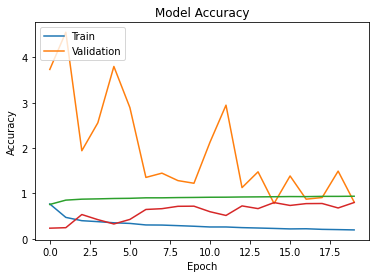

In [4]:

datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    rotation_range=20,
    validation_split=0.1,
)

datagen.fit(X_train)

hist = model.fit(
    datagen.flow(X_train, y_train, batch_size=100),
    epochs=20,
    callbacks=[checkpoint],
    validation_data=(X_test, y_test),
)

plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"], loc="upper left")
plt.savefig(f"{ROOT_FOLDER}loss per epoch")

plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"], loc="upper left")
plt.savefig(f"{ROOT_FOLDER}accuracy per epoch")

model.save(f"{ROOT_FOLDER}")


In [1]:
from keras.models import load_model
model = load_model("best_model_88.hdf5")


2022-02-19 11:41:26.131949: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train = np.asarray([cv2.resize(x, (MIN_SIZE, MIN_SIZE)) for x in X_train])
X_test = np.asarray([cv2.resize(x, (MIN_SIZE, MIN_SIZE)) for x in X_test])
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

test_results = model.evaluate(X_test, y_test)
with open(f"{ROOT_FOLDER}test_results.txt", "w+") as f:
    f.write("\n".join([str(x) for x in test_results]))

X_big = np.concatenate((X_test, X_train), axis=0)
y_big = np.concatenate((y_test, y_train), axis=0)

test_results = model.evaluate(X_big, y_big)
with open(f"{ROOT_FOLDER}overall_results.txt", "w+") as f:
    f.write("\n".join([str(x) for x in test_results]))

1875/1875 [==============================] - 211s 112ms/step - loss: 0.2941 - accuracy: 0.9154
